In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS

from pyro.infer.mcmc.api import MCMC

import pyro.optim as optim
import pyro.poutine as poutine

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.4')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

DATA_URL = "https://d2fefpcigoriu7.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

data = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
        self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.linear(x) + (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

p = 2  # number of features
regression_model = RegressionModel(p)

def model(x_data, y_data):
    # weight and bias priors
    w_prior = Normal(torch.zeros(1, 2), torch.ones(1, 2)).to_event(1)
    b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    f_prior = Normal(0., 1.)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior, 'factor': f_prior}
    scale = pyro.sample("sigma", Uniform(0., 10.))
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.plate("map", len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, scale),
                    obs=y_data)
        return prediction_mean
    
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=0, num_chains=1)
mcmc.run(x_data, y_data)

sample: 100%|██████████| 100/100 [00:04<00:00, 20.80it/s, step size=3.12e-02, acc. prob=0.943]


In [2]:
from pyro.infer.mcmc.util import predictive
samples = mcmc.get_samples()
#trace = predictive(model, samples, x_data, y_data, return_trace=True)

In [3]:
def predict_mcmc(model, model_samples, *args, **kwargs):
    log_prob = []
    for i in range(len(model_samples)):
        model_trace = poutine.trace(poutine.condition(model, model_samples)).get_trace(*args, **kwargs)
        model_trace.compute_log_prob()
        log_prob.append(model_trace.nodes['obs']['log_prob'])
    return torch.stack(log_prob)

In [4]:
samples = [{k: v[i] for k, v in mcmc.get_samples().items()} for i in range(100)]

In [5]:
log_prob = predict_mcmc(model, samples, x_data, None)

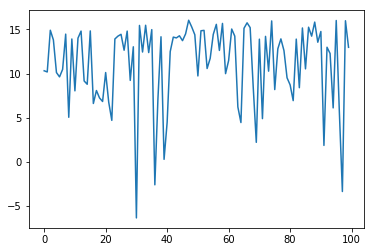

In [6]:
plt.plot(-0.025*torch.sum(log_prob, dim=1).numpy())